In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

weight =  np.array([0.0 for i in range(20)])
weight[7],weight[5] = 0.64854,0.35146
# 读取数据
dataset = pd.read_excel('StockData.xlsx', index_col=0)
names = dataset.columns.to_list()

Lt = (dataset* weight).sum(axis=1).diff()
Lt = Lt[Lt.index.year>2018]

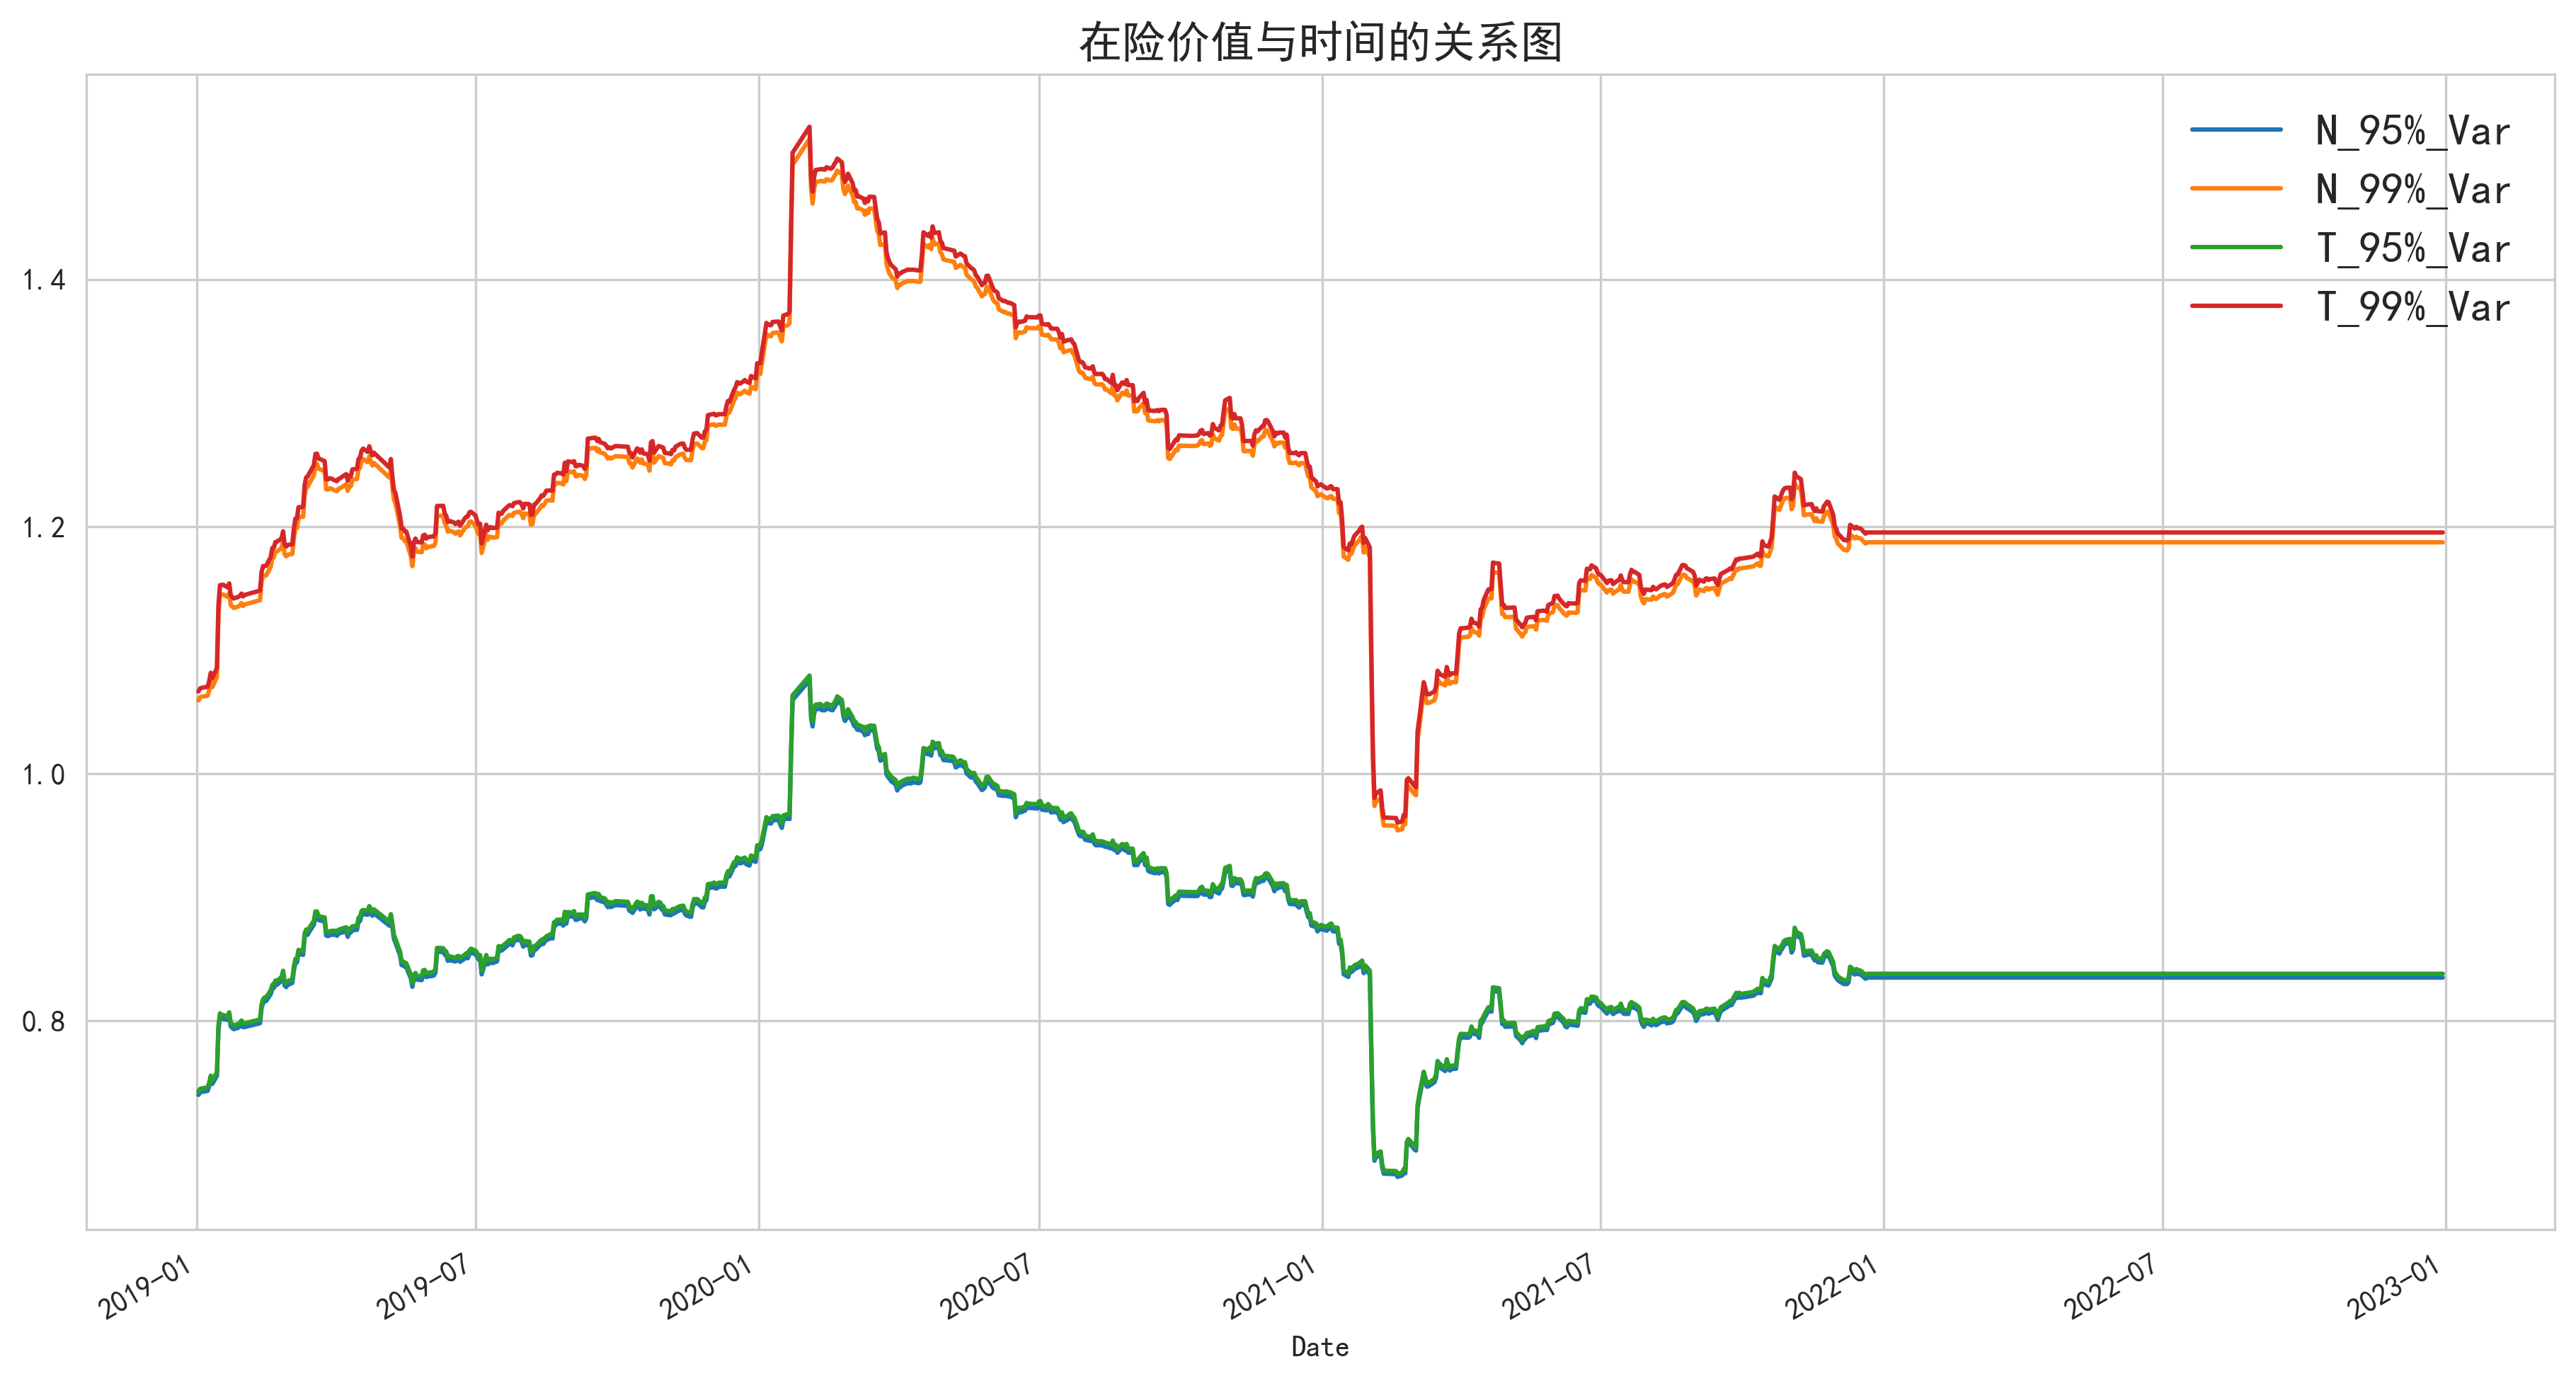

In [2]:
from scipy.stats import t
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    # 用来正常显示负号

d = 250
zt_vars_95 = []
zt_vars_99 = []
t_vars_95 = []
t_vars_99 = []

for i in range(value.shape[0]):
    value_ = value[i:i+d] if i < 720 else value[-d:]
    n = value_.shape[0]
    u = value_.mean()
    p = np.sqrt(np.cov(value_))
    zt_vars_95.append(u - 1.645*p)
    zt_vars_99.append(u - 2.326*p)
    t_vars_95.append(t.ppf(0.05, df=n-1,loc=u, scale=p))
    t_vars_99.append(t.ppf(0.01, df=n-1,loc=u, scale=p))

table = pd.DataFrame(index=value.index)
table['N_95%_Var'] = np.array(zt_vars_95)
table['N_99%_Var'] = np.array(zt_vars_99)
table['T_95%_Var'] = np.array(t_vars_95)
table['T_99%_Var'] = np.array(t_vars_99)
fig, ax = plt.subplots(figsize=(15, 8), dpi=300)
table = np.abs(table)
table.plot(ax=ax)
plt.title('在险价值与时间的关系图',fontsize=15)
plt.legend(frameon=False, fontsize=15)
plt.savefig('./imgs/在险价值与时间的关系图.png', transparent=True)
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

data_ = dataset[dataset.index.year>2018]
X = data_[data_.index.year<2022]

X_target = data_[data_.index.year==2022]
Y = table[table.index.year<2022]
# y = Y['N_95%_Var']
scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [4]:
from sklearn.metrics import mean_squared_error # 均方误差
from sklearn.neural_network import MLPRegressor

layris = 501
best_sizes = (1,)
best_score = 0
scores=[]
val_mses=[]
mses=[]

for i in range(1, layris):
    model = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(i,), random_state=123, max_iter=100000)
    model.fit(X_train_s, y_train)
    score = model.score(X_test_s, y_test)
    val_mse = mean_squared_error(y_test, model.predict(X_test_s))
    mse = mean_squared_error(y_train, model.predict(X_train_s))
    scores.append(score)
    mses.append(mse)
    val_mses.append(val_mse)
    if best_score < score:
        best_score = score
        best_sizes = (i, )  


KeyboardInterrupt



In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    # 用来正常显示负号

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=300)

index = np.argmax(scores)
start = 1

index = np.argmax(scores)
index2 = np.argmin(val_mses)

ax[0].plot(range(start, layris), scores, 'o-', linewidth=0.3, markersize=0.5)
ax[0].axvline(range(start, layris)[index], linestyle='--', color='k', linewidth=0.3)
ax[0].set_xlabel('Number of Nodes')
ax[0].set_ylabel('R2')
ax[0].set_title('Test Set R2 vs Number of Nodes')

ax[1].plot(mses, 'k', label='Train', linewidth=0.3)
ax[1].plot(val_mses, 'b', label='Validation', linewidth=0.3)
ax[1].axvline(index2 + 1, linestyle='--', color='k', linewidth=0.3)
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8), dpi=300)
model = MLPRegressor(solver='lbfgs', hidden_layer_sizes=best_sizes, random_state=132, max_iter=100000)
print(best_sizes)
model.fit(X_train_s, y_train)
# model.intercepts_
# model.coefs_
# model.n_iter_
print(f"R方:{model.score(X_test_s, y_test):.4f}; 迭代次数{model.n_iter_}")
df = pd.DataFrame(model.predict(scaler.transform(X_target)),index=X_target.index,columns=['N_95%_Var','N_99%_Var','T_95%_Var','T_99%_Var'])
table = pd.concat([Y, df], axis=0)
table.plot(ax=ax)
plt.title('基于单隐藏层神经网络估计_在险价值与时间的关系图',fontsize=15)
plt.legend(frameon=False, fontsize=12)
# plt.savefig('./imgs/收益率曲线图.png', transparent=True)
plt.show()

In [ ]:
from prophet import Prophet
from scipy.stats import t
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    # 用来正常显示负号

# 首先尝试对Lt进行预测，发现效果并不是很好，
# pip install prophet
dfdata = pd.DataFrame(value)
dfdata.reset_index(inplace=True)
dfdata.rename(columns={"Date":"ds"},inplace=True)
dfdata.rename(columns={0:"y"},inplace=True)
m = Prophet()
m.fit(dfdata)
future = m.make_future_dataframe(periods=250)
forecast = m.predict(future)

dfforecast= forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
pd.set_option('display.max_rows', dfforecast.shape[0]+1)
dfforecast = dfforecast.set_index('ds')["yhat"][-250:]

value.name='yhat'
value = pd.concat([value, dfforecast], axis=0)
fig1 = m.plot(forecast)
d = 250
zt_vars_95 = []
zt_vars_99 = []
t_vars_95 = []
t_vars_99 = []
for i in range(value.shape[0]-d):
    value_ = value[i:i+d]
    n = value_.shape[0]
    u = value_.mean()
    p = np.sqrt(np.cov(value_))
    zt_vars_95.append(u - 1.645*p)
    zt_vars_99.append(u - 2.326*p)
    t_vars_95.append(t.ppf(0.05, df=n-1,loc=u,scale=p))
    t_vars_99.append(t.ppf(0.01, df=n-1,loc=u,scale=p))

table = pd.DataFrame(index=value.index[:970])
table['N_95%_Var'] = np.array(zt_vars_95)
table['N_99%_Var'] = np.array(zt_vars_99)
table['T_95%_Var'] = np.array(t_vars_95)
table['T_99%_Var'] = np.array(t_vars_99)
table = np.abs(table)

fig, ax = plt.subplots(figsize=(15, 8), dpi=300)

table.plot(ax=ax)
plt.title('在险价值Var与时间的关系图',fontsize=15)
plt.legend(frameon=False, fontsize=15)
# plt.savefig('./imgs/收益率曲线图.png', transparent=True)
plt.show()

In [ ]:
from prophet import Prophet

# 使用prophet对股票价格进行预测
datasetforecast=pd.DataFrame()
for name in names:
    df = dataset[name].reset_index()
    df = df.rename(columns={"Date":"ds",name:"y"})
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=250)
    forecast = m.predict(future)
    dfforecast= forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
    pd.set_option('display.max_rows', dfforecast.shape[0]+1)
    dfforecast = dfforecast.set_index('ds')["yhat"][-250:]
    df = df.set_index('ds')['y']
    datasetforecast[name] = pd.concat([df, dfforecast], axis=0)


In [ ]:
from scipy.stats import t
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    # 用来正常显示负号

value = (datasetforecast* weight).sum(axis=1).diff()
value = value[value.index.year>2018]

d = 250
zt_vars_95 = []
zt_vars_99 = []
t_vars_95 = []
t_vars_99 = []

for i in range(value.shape[0]):
    value_ = value[i:i+d] if i < 720 else value[-d:]
    n = value_.shape[0]
    u = value_.mean()
    p = np.sqrt(np.cov(value_))
    zt_vars_95.append(u - 1.645*p)
    zt_vars_99.append(u - 2.326*p)
    t_vars_95.append(t.ppf(0.05, df=n-1,loc=u, scale=p))
    t_vars_99.append(t.ppf(0.01, df=n-1,loc=u, scale=p))

table = pd.DataFrame(index=value.index)
table['N_95%_Var'] = np.array(zt_vars_95)
table['N_99%_Var'] = np.array(zt_vars_99)
table['T_95%_Var'] = np.array(t_vars_95)
table['T_99%_Var'] = np.array(t_vars_99)

table = np.abs(table[:-250])
fig, ax = plt.subplots(figsize=(15, 8), dpi=300)

table.plot(ax=ax)
plt.title('在险价值与时间的关系图',fontsize=15)
plt.legend(frameon=False, fontsize=15)
plt.savefig('./imgs/在险价值与时间的关系图.png', transparent=True)
plt.show()

In [5]:
# 长短期深度学习网络
# 导入必要的库
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

weight =  np.array([0.0 for i in range(20)])
weight[7],weight[5] = 0.64854,0.35146

# 读取数据
dataset = pd.read_excel('StockData.xlsx', index_col=0)
names = dataset.columns.to_list()

# 数据预处理：归一化
scaler = MinMaxScaler()
prices = dataset[names[0]].values
prices = scaler.fit_transform(prices.reshape(-1, 1))

# 划分数据集为训练集和测试集
train_size = int(len(prices) * 0.8)
train_data, test_data = prices[:train_size], prices[train_size:]

In [6]:
# 创建时间窗口数据
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i+seq_length])
    return np.array(sequences)

seq_length = 2
X_train = create_sequences(train_data, seq_length)
y_train = train_data[seq_length:]
X_test = create_sequences(test_data, seq_length)
y_test = test_data[seq_length:]

In [10]:
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# 创建LSTM模型
model = Sequential()
model.add(LSTM(256, input_shape=(seq_length, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mse','mae'])

# 保存模型
checkpoint_path_save = r'lstm_stock.ckpt'

# 如果模型存在，就加载模型
if os.path.exists(checkpoint_path_save + '.index'):
    print('--------------------load the model----------------------')
    model.load_weights(checkpoint_path_save)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_save,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss'
)

# 模型训练
history = model.fit(X_train, y_train, batch_size=64, epochs=300, validation_data=(X_test, y_test), callbacks=[cp_callback])

--------------------load the model----------------------
Epoch 1/300
16/16 [==============================] - 2s 24ms/step - loss: 5.3985e-04 - mse: 5.3985e-04 - mae: 0.0168 - val_loss: 56.6677 - val_mse: 56.6677 - val_mae: 7.5123
Epoch 2/300
16/16 [==============================] - 0s 7ms/step - loss: 5.1237e-04 - mse: 5.1237e-04 - mae: 0.0164 - val_loss: 56.7280 - val_mse: 56.7280 - val_mae: 7.5161
Epoch 3/300
16/16 [==============================] - 0s 7ms/step - loss: 4.4170e-04 - mse: 4.4170e-04 - mae: 0.0145 - val_loss: 56.7025 - val_mse: 56.7025 - val_mae: 7.5145
Epoch 4/300
16/16 [==============================] - 0s 7ms/step - loss: 4.4978e-04 - mse: 4.4978e-04 - mae: 0.0144 - val_loss: 56.6927 - val_mse: 56.6927 - val_mae: 7.5138
Epoch 5/300
16/16 [==============================] - 0s 7ms/step - loss: 4.4338e-04 - mse: 4.4338e-04 - mae: 0.0144 - val_loss: 56.7203 - val_mse: 56.7203 - val_mae: 7.5157
Epoch 6/300
16/16 [==============================] - 0s 7ms/step - loss: 4.51

In [13]:
Dict = history.history
dict(Dict)

{'loss': [0.0005398456123657525,
  0.0005123698501847684,
  0.0004417019954416901,
  0.0004497798508964479,
  0.00044337919098325074,
  0.00045189011143520474,
  0.00046822757576592267,
  0.00044256786350160837,
  0.0004516786721069366,
  0.0004535522894002497,
  0.0004772055253852159,
  0.00046395210665650666,
  0.0004365802160464227,
  0.0005130202043801546,
  0.0004463194636628032,
  0.00044504107790999115,
  0.0004509876889642328,
  0.00046249685692600906,
  0.0004368316731415689,
  0.0004406149382703006,
  0.0004366366483736783,
  0.00045753418817184865,
  0.00046516393194906414,
  0.00045420113019645214,
  0.00044189911568537354,
  0.000448630511527881,
  0.00045713133295066655,
  0.00044071246520616114,
  0.00044586561853066087,
  0.0004595927312038839,
  0.0004466351238079369,
  0.00043456192361190915,
  0.00044030696153640747,
  0.0004442381323315203,
  0.0004470997955650091,
  0.0004377953882794827,
  0.0004438477335497737,
  0.0004367269284557551,
  0.00047873330186121166,
 

8/8 [==============================] - 0s 2ms/step
R2:0.9793133710806092


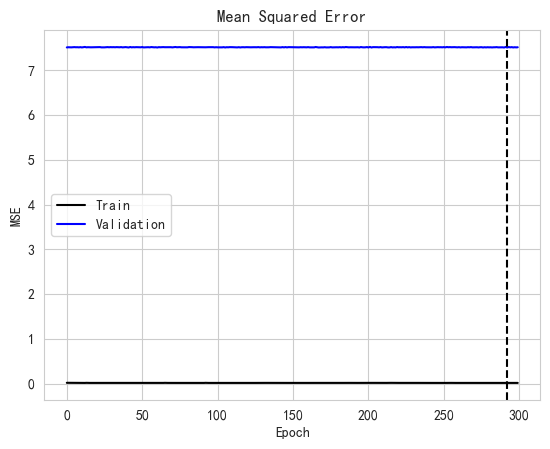

In [14]:

import matplotlib.pyplot as plt


model.evaluate(X_test, y_test)
pred = np.squeeze(model.predict(X_test))
print(f'R2:{[np.corrcoef(y_test.T, pred) ** 2][0][0][1]}')

val_mse = Dict['val_mae']
index = np.argmin(val_mse)
plt.plot(Dict['mae'], 'k', label='Train')
plt.plot(Dict['val_mae'], 'b', label='Validation')
plt.axvline(index,linestyle='--', color='k')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('Mean Squared Error')
plt.legend()
plt.show()

8/8 [==============================] - 0s 2ms/step


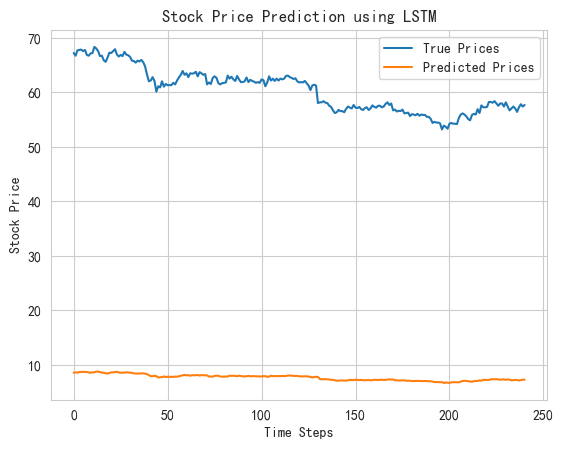

In [15]:
# 预测未来股价
predicted_prices = model.predict(X_test)

# 反归一化预测结果
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test = scaler.inverse_transform(y_test)

# 绘制预测结果
plt.plot(y_test, label='True Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.show()